# Data Preprocessing

## Get the Data

In [1]:
import os

In [2]:
def load_data(path):
    """
    Load date from file
    """
    input_file = os.path.join(path)
    with open(input_file, 'r', encoding='utf-8') as f:
        return f.read()

In [3]:
raw_data_path = 'raw_data.txt'
raw_data = load_data(raw_data_path)

## Explore the Data

In [4]:
import re

In [5]:
def clean1(raw_list):
    """
    Merge eneity
    """
    for i in range(len(raw_list)):
        if len(raw_list[i]) == 3:
            for j in range(3):
                if not re.search('<e1>.+</e1>', raw_list[i][j]) and not re.search('<e2>.+</e2>', raw_list[i][j]):
                    raw_list[i][j] = raw_list[i][j] + '+' + raw_list[i][j+1]
                    del raw_list[i][j+1]
                    break
        elif len(raw_list[i]) == 4:
             raw_list[i][0] = raw_list[i][0] + '+' + raw_list[i][1]
             raw_list[i][1] = raw_list[i][2] + '+' + raw_list[i][3]
             raw_list[i].pop()
             raw_list[i].pop()
    return raw_list

def clean2(raw_list):
    """
    Remove "'s"'<e1>''</e1>''<e2>''</e2>'
    """
    for i in range(len(raw_list)):
        for j in range(2):
            if raw_list[i][j].endswith('s'):
                raw_list[i][j] = raw_list[i][j][:-2]
    new_list = [[w[4:-5] for w in s] for s in raw_list]
    return new_list

def substitute(sentences, eneities):
    """
    Substitute the raw eneities of sentences with eneities
    """
    for i in range(len(sentences)):
        sentences[i], _ = re.subn('<e1>.+\s?.+</e1>', eneities[i][0], sentences[i])
        sentences[i], _ = re.subn('<e2>.+\s?.+</e2>', eneities[i][1], sentences[i])
    return sentences     

In [6]:
raw_data = raw_data.strip().split('\t')[1:]
new_data = [line.split('\n')[:2] for line in raw_data]
raw_sentences = [line[0] for line in new_data]
relations = [line[1] if line[1] == 'Other' else line[1][:-7] for line in new_data]
sen_words = [[w.strip("\"':;.,?!\)(").lower() for w in s.split()] for s in raw_sentences]
sen_words = [[w[:-2] if w.endswith("'s") else w for w in s ] for s in sen_words]
raw_eneities = [[w for w in s 
                 if re.search('<e1>', w) or re.search('</e1>', w) or re.search('<e2>', w) or re.search('</e2>', w)] 
                 for s in sen_words]
eneities = clean2(clean1(raw_eneities))
sentences = substitute([' '.join(s) for s in sen_words], eneities)

In [7]:
sen_words

[['the',
  'system',
  'as',
  'described',
  'above',
  'has',
  'its',
  'greatest',
  'application',
  'in',
  'an',
  'arrayed',
  '<e1>configuration</e1>',
  'of',
  'antenna',
  '<e2>elements</e2>'],
 ['the',
  '<e1>child</e1>',
  'was',
  'carefully',
  'wrapped',
  'and',
  'bound',
  'into',
  'the',
  '<e2>cradle</e2>',
  'by',
  'means',
  'of',
  'a',
  'cord'],
 ['the',
  '<e1>author</e1>',
  'of',
  'a',
  'keygen',
  'uses',
  'a',
  '<e2>disassembler</e2>',
  'to',
  'look',
  'at',
  'the',
  'raw',
  'assembly',
  'code'],
 ['a', 'misty', '<e1>ridge</e1>', 'uprises', 'from', 'the', '<e2>surge</e2>'],
 ['the',
  '<e1>student</e1>',
  '<e2>association</e2>',
  'is',
  'the',
  'voice',
  'of',
  'the',
  'undergraduate',
  'student',
  'population',
  'of',
  'the',
  'state',
  'university',
  'of',
  'new',
  'york',
  'at',
  'buffalo'],
 ['this',
  'is',
  'the',
  'sprawling',
  '<e1>complex</e1>',
  'that',
  'is',
  'peru',
  'largest',
  '<e2>producer</e2>',
  '

### Sentence

In [7]:
sentences[8]

'the lawsonite was contained in a platinum+crucible and the counter-weight was a plastic crucible with metal pieces'

In [8]:
MAX_LEN = max([len(s.split()) for s in sentences])
print('MAX_LEN =', MAX_LEN)

MAX_LEN = 85


### Eneity

In [9]:
eneities[8]

['lawsonite', 'platinum+crucible']

### Relation

In [10]:
relations[8]

'Content-Container'

## Tokenize Text

### Build Vocabulary

In [8]:
from collections import Counter

In [9]:
def get_vocab(text):
    """
    Get vocabulary and word's counts
    """
    vocab_counts = Counter(w for t in text for w in t.split())
    vocab = sorted(vocab_counts, key=vocab_counts.get, reverse=True)
    return vocab

In [10]:
sen_vocab = get_vocab(sentences)
rel_vocab = get_vocab(relations)

In [11]:
VOCAB_SIZE = len(sen_vocab) + 1
print('VOCAB_SIZE =', VOCAB_SIZE)

VOCAB_SIZE = 20469


In [12]:
print(rel_vocab)

['Other', 'Cause-Effect', 'Component-Whole', 'Entity-Destination', 'Product-Producer', 'Entity-Origin', 'Member-Collection', 'Message-Topic', 'Content-Container', 'Instrument-Agency']


In [13]:
CATEGORY = len(rel_vocab)
print('CATEGORY =', CATEGORY)

CATEGORY = 10


### Index Words

In [14]:
PAD = 0

In [15]:
sen_word2idx = {w: i+1 for i, w in enumerate(sen_vocab)}
sen_word2idx['<PAD>'] = PAD
sen_idx2word = {i: w for w, i in sen_word2idx.items()}
rel_word2idx = {w: i for i, w in enumerate(rel_vocab)}
rel_idx2word = {i: w for w, i in rel_word2idx.items()}

In [16]:
sen_id = [[sen_word2idx[w] for w in s.split()] for s in sentences]
rel_id = [[rel_word2idx[w] for w in s.split()] for s in relations]
ent_id = [[sen_word2idx[w] for w in s] for s in eneities]

## Creat Word Embeddings with Glove

In [20]:
EMBEDDING_DIM = 300
SEED = 42

### Read Glove

In [21]:
glove_n_symbols = !wc -l /Users/lizhn7/Downloads/DATA/Glove/glove.42B.300d.txt
glove_n_symbols = int(glove_n_symbols[0].split()[0])
glove_n_symbols

1917495

In [22]:
import numpy as np

In [23]:
glove_idx_dict = {}
glove_embedding_weights = np.empty((glove_n_symbols, EMBEDDING_DIM))
globale_scale = 0.1
with open('/Users/lizhn7/Downloads/DATA/Glove/glove.42B.300d.txt', 'r') as fp:
    idx = 0
    for l in fp:
        l = l.strip().split()
        word = l[0]
        glove_idx_dict[word] = idx
        glove_embedding_weights[idx, :] = [float(n) for n in l[1:]]
        idx += 1
glove_embedding_weights *= globale_scale

In [24]:
glove_embedding_weights.std()

0.029510716778162933

### Use Glove to Initialize Embedding Matrix

In [25]:
# generate random embedding with same scale as glove
np.random.seed(SEED)
shape = (VOCAB_SIZE, EMBEDDING_DIM)
scale = glove_embedding_weights.std()*np.sqrt(12)/2
embedding = np.random.uniform(low=-scale, high=scale, size=shape)

In [26]:
clean_dict = {
    'semi-': 'semi', 'attack-': 'attack', 'squatter-': 'squatter', 'foam-': 'foam',
    'vboost-': 'vboost', 'con-': 'con', 'crush-': 'crush', 'mag-': 'mag',
    'four-year-': 'four+year', 'is-': 'is', 'guard-': 'guard', 'similar--': 'similar',
    'low-': 'low', '10-': '10', "he'd": 'he+would', "she'd": 'she+would', "wasn't": 'was+not',
    "we've": 'we+have', "they've": 'they+have', "who've": 'who+have', "they're": 'they+are',
    'codario-ferrino': 'ferrino', 'high-definition+broadcast': 'highdefinition+broadcast',
    'white-o-mornin': 'white-mornin', "abu'l-qasim": 'abu-qasim', 'outer-surface+a': 'surface',
    'hai-hsi-pu': 'hai-hsi', '--40': '40', 'braich-y-pwll': 'braich-pwll',
    'gold-plated+cylinder': 'goldplated+cylinder', 'the71-year-old': '71-year-old',
    'not-too-acidic': 'not-acidic', 'e-mail+address': 'email+address', 'expressed(r-es': 'expressed',
    'e-post+card': 'epost+card', 'spout-to-cup': 'spout-cup',
    'on-going+events': 'ongoing+events', 're-hydration+tablets': 'rehydration+tablets',
    'stock-index+futures': 'stock+futures', 'freeman-walter-abele': 'walter-abele',
    'barrister-cum-writer': 'barrister+writer', 'mah-jongg+set': 'mahjongg+set', 
    'intricately-ptterned': 'intricately-patterned', 'eight-year-old+boy': 'boy', 
    'multi-user+dungeon': 'multiuser+dungeon', 'teacher-to-learner': 'teacher-learner'
}

In [27]:
# copy from glove weights of words that appear in sen_idx2word
c = 0
for i in range(VOCAB_SIZE):
    w = sen_idx2word[i]
    w = clean_dict.get(w, w)
    g = glove_idx_dict.get(w)
    if g is None and w.find('+') != -1:
        w1 = w[:w.find('+')]
        g1 = glove_idx_dict.get(w1)
        w2 = w[w.find('+')+1:]
        g2 = glove_idx_dict.get(w2)
        if g1 is not None and g2 is not None:
            embedding[i, :] = glove_embedding_weights[g1, :]+glove_embedding_weights[g2, :]
            c += 1
    if g is None and w.find('-') != -1:
        w1 = w[:w.find('-')]
        g1 = glove_idx_dict.get(w1)
        w2 = w[w.find('-')+1:]
        g2 = glove_idx_dict.get(w2)
        if g1 is not None and g2 is not None:
            embedding[i, :] = glove_embedding_weights[g1, :]+glove_embedding_weights[g2, :]
            c += 1
    if g is not None:
        embedding[i, :] = glove_embedding_weights[g, :]
        c += 1
print('{num_tokens}--{percentage:4.2f}% tokens in vocabulary found in glove and copied to embedding.'.format(num_tokens=c, percentage=c/float(VOCAB_SIZE)*100))

20045--97.93% tokens in vocabulary found in glove and copied to embedding.


## Build Dateset

In [28]:
from keras.preprocessing import sequence
from keras.utils import np_utils

Using TensorFlow backend.


In [29]:
def convert_seq(sen_id, rel_id):
    """
    Pad sen_id to MAX_LEN and encode rel_id to one-hot encoding
    """
    new_sen_id = sequence.pad_sequences(sen_id, maxlen=MAX_LEN, value=PAD, padding='post')
    new_rel_id = np_utils.to_categorical(np.asarray(rel_id))
    return new_sen_id, new_rel_id

def convert_ent(ent_id, sen_id):
    """
    Convert data to entity-word vectors 
    """
    EW1 = []
    EW2 = []
    for i in range(len(ent_id)):
        EW1.append([[ent_id[i][0], w] for w in sen_id[i]])
        EW2.append([[ent_id[i][1], w] for w in sen_id[i]])
    EW1 = sequence.pad_sequences(EW1, maxlen=MAX_LEN, value=PAD, padding='post')
    EW2 = sequence.pad_sequences(EW2, maxlen=MAX_LEN, value=PAD, padding='post')
    return EW1, EW2

In [30]:
sen_X1, Y = convert_seq(sen_id, rel_id)
en_X1, en_X2 = convert_ent(ent_id, sen_id) 

In [31]:
from sklearn.model_selection import train_test_split

In [32]:
sen_X1_train, sen_X1_val, Y_train, Y_val = train_test_split(sen_X1, Y, test_size=1000, random_state=SEED)
en_X1_train, en_X1_val, en_X2_train, en_X2_val = train_test_split(en_X1, en_X2, test_size=1000, random_state=SEED)

## Save Data

In [33]:
import h5py

In [34]:
fh = h5py.File('train.h5','w')
fh.create_dataset('train_sen_X1', data = sen_X1_train)
fh.create_dataset('train_Y', data = Y_train)
fh.create_dataset('train_en_X1',data = en_X1_train[:, :, 0])
fh.create_dataset('train_en_X2',data = en_X2_train[:, :, 0])
fh.close()

In [35]:
fh = h5py.File('val.h5', 'w')
fh['val_sen_X1'] = sen_X1_val
fh['val_Y'] = Y_val
fh['val_en_X1'] = en_X1_val[:, :, 0]
fh['val_en_X2'] = en_X2_val[:, :, 0]
fh.close()

In [36]:
with h5py.File('emb.h5','w') as fh:
    fh['embedding'] = embedding

In [37]:
import pickle

In [38]:
with open('index.pkl', 'wb') as fp:
    pickle.dump((sen_word2idx, sen_idx2word, rel_word2idx, rel_idx2word), fp, -1)

# Checkpoint

In [1]:
import h5py
import pickle

fh = h5py.File('train.h5', 'r')
sen_X1_train = fh['train_sen_X1'][:]
Y_train = fh['train_Y'][:]
en_X1_train = fh['train_en_X1'][:]
en_X2_train = fh['train_en_X2'][:]
fh.close()

sen_X1_train.shape, Y_train.shape, en_X1_train.shape, en_X2_train.shape

with h5py.File('val.h5', 'r') as fh:
    sen_X1_val = fh['val_sen_X1'][:]
    Y_val = fh['val_Y'][:]
    en_X1_val = fh['val_en_X1'][:]
    en_X2_val = fh['val_en_X2'][:]

sen_X1_val.shape, Y_val.shape, en_X1_val.shape, en_X2_val.shape

with h5py.File('emb.h5','r') as fh:  
    embedding = fh['embedding'][:] 

with open('index.pkl', 'rb') as fp:
    sen_word2idx, sen_idx2word, rel_word2idx, rel_idx2word = pickle.load(fp)

# Build Model

## Set Hyperparameters

In [2]:
NUM_EPOCHS = 256
BATCH_SIZE = 32
MAX_LEN = 85
VOCAB_SIZE = 20469
CATEGORY = 10
EMBEDDING_SIZE = 300
CNN_SIZE = 128
#CNN_HIDDEN_SIZE = 600
WINDOW_SIZE = 3
#POOL_SIZE = 2
ATT_HIDDEN_SIZE = 120
MLP_HIDDEN1_SIZE = 240
MLP_HIDDEN2_SIZE = 120
LEARNING_RATE = 0.001
PAD = 0
SEED = 42

## Build Graph

In [3]:
from keras.layers import Input, Embedding
from keras.layers import Conv1D, GlobalMaxPooling1D, MaxPooling1D
from keras.layers import Dense, Flatten, Activation
from keras.layers import concatenate, dot
from keras.layers import TimeDistributed
from keras.models import Model
from keras import optimizers
from keras.initializers import RandomUniform  

Using TensorFlow backend.


### Sentence Convolution

In [4]:
sen_input = Input(shape=(MAX_LEN,), dtype='int32', name='Sentence-Word')
sen_emb = Embedding(input_dim=VOCAB_SIZE, output_dim=EMBEDDING_SIZE,
                    weights=[embedding], input_length=MAX_LEN, name='Word-Embedding',
                    trainable=True)(sen_input)
sen_conv = Conv1D(CNN_SIZE, WINDOW_SIZE, padding='same', activation='tanh', name='Convolution1', kernel_initializer=RandomUniform(-0.1, 0.1, SEED), bias_initializer=RandomUniform(-0.1, 0.1, SEED))(sen_emb)
#sen_conv = MaxPooling1D(POOL_SIZE, name='Maxpooling1')(sen_conv)
#sen_conv = Conv1D(1024, WINDOW_SIZE, padding='same', activation='elu', name='Convolution2')(sen_conv)
#sen_conv = MaxPooling1D(POOL_SIZE, name='Maxpooling2')(sen_conv)
#sen_conv = Conv1D(512, WINDOW_SIZE, padding='same', activation='elu', name='Convolution3')(sen_conv)
#sen_vec = GlobalMaxPooling1D(name='Max-Pooling')(sen_conv)
sen_vec = GlobalMaxPooling1D(name='Sentence-Convolution-Feature')(sen_conv)
#sen_vec = Dense(CNN_HIDDEN_SIZE, activation='tanh', name='Sentence-Convolution-Feature', kernel_initializer=RandomUniform(-0.1, 0.1, SEED), bias_initializer=RandomUniform(-0.1, 0.1, SEED))(sen_vec)

### Attention-based Context Selection w.r.t. Eneity 1

In [5]:
en1_input = Input(shape=(MAX_LEN,), dtype='int32', name='Eneity1')
en1_emb = Embedding(input_dim=VOCAB_SIZE, output_dim=EMBEDDING_SIZE,
                    weights=[embedding], input_length=MAX_LEN, name='Eneity1-Embedding',
                   trainable=True)(en1_input)
en1_word = concatenate([en1_emb, sen_emb], axis=-1, name='Eneity1-Word')
en1_word_hidden = TimeDistributed(Dense(ATT_HIDDEN_SIZE, activation='tanh', name='Attention1-Hidden', kernel_initializer=RandomUniform(-0.1, 0.1, SEED), bias_initializer=RandomUniform(-0.1, 0.1, SEED)), name='Computation1-Unit')(en1_word)
en1_word_score = TimeDistributed(Dense(1, activation=None, name='Attention1-Weight', kernel_initializer=RandomUniform(-0.1, 0.1, SEED), bias_initializer=RandomUniform(-0.1, 0.1, SEED)), name='Computation1-Score')(en1_word_hidden)
en1_word_score = Activation('softmax', name='Softmax1')(en1_word_score)
en1_vec = dot([en1_word_score, sen_emb], axes=(1, 1), name='Attention1_based-Context-Feature')
en1_vec = Flatten(name='Flatten1')(en1_vec)

### Attention-based Context Selection w.r.t. Eneity 2

In [6]:
en2_input = Input(shape=(MAX_LEN,), dtype='int32', name='Eneity2')
en2_emb = Embedding(input_dim=VOCAB_SIZE, output_dim=EMBEDDING_SIZE,
                    weights=[embedding], input_length=MAX_LEN, name='Eneity2-Embedding',
                   trainable=True)(en2_input)
en2_word = concatenate([en2_emb, sen_emb], axis=-1, name='Eneity2-Word')
en2_word_hidden = TimeDistributed(Dense(ATT_HIDDEN_SIZE, activation='tanh', name='Attention2-Hidden', kernel_initializer=RandomUniform(-0.1, 0.1, SEED), bias_initializer=RandomUniform(-0.1, 0.1, SEED)), name='Computation2-Unit')(en2_word)
en2_word_score = TimeDistributed(Dense(1, activation=None, name='Attention2-Weight', kernel_initializer=RandomUniform(-0.1, 0.1, SEED), bias_initializer=RandomUniform(-0.1, 0.1, SEED)), name='Computation2-Score')(en2_word_hidden)
en2_word_score = Activation('softmax', name='Softmax2')(en2_word_score)
en2_vec = dot([en2_word_score, sen_emb], axes=(1, 1), name='Attention2_based-Context-Feature')
en2_vec = Flatten(name='Flatten2')(en2_vec)

### MLP Layer

In [7]:
joint_vec = concatenate([sen_vec, en1_vec, en2_vec], axis=-1, name='Concatenated-Feature')
joint_vec = Dense(MLP_HIDDEN1_SIZE, activation='tanh', name='MLP-Hidden1', kernel_initializer=RandomUniform(-0.1, 0.1, SEED), bias_initializer=RandomUniform(-0.1, 0.1, SEED))(joint_vec)
#joint_vec = Dense(MLP_HIDDEN1_SIZE, activation='elu', name='MLP-Hidden1', kernel_initializer=RandomUniform(-0.1, 0.1, SEED), bias_initializer=RandomUniform(-0.1, 0.1, SEED))(sen_vec)
joint_vec = Dense(MLP_HIDDEN2_SIZE, activation='tanh', name='MLP-Hidden2', kernel_initializer=RandomUniform(-0.1, 0.1, SEED), bias_initializer=RandomUniform(-0.1, 0.1, SEED))(joint_vec)
output = Dense(CATEGORY, activation='softmax', name='Output', kernel_initializer=RandomUniform(-0.1, 0.1, SEED), bias_initializer=RandomUniform(-0.1, 0.1, SEED))(joint_vec)

### Compile

In [8]:
model = Model(inputs=[sen_input, en1_input, en2_input], outputs=output)
SGD = optimizers.SGD(lr=LEARNING_RATE, momentum=0.9, nesterov=True)
model.compile(optimizer=SGD, loss='categorical_crossentropy', metrics=['acc'])

In [9]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
Sentence-Word (InputLayer)       (None, 85)            0                                            
____________________________________________________________________________________________________
Eneity1 (InputLayer)             (None, 85)            0                                            
____________________________________________________________________________________________________
Eneity2 (InputLayer)             (None, 85)            0                                            
____________________________________________________________________________________________________
Word-Embedding (Embedding)       (None, 85, 300)       6140700     Sentence-Word[0][0]              
___________________________________________________________________________________________

## Model Evaluation

In [10]:
import numpy as np
from sklearn.metrics import f1_score

In [11]:
def macro_f1_score(x, y_true):
    """
    Calculate macro-averaged F1-score
    """
    y_pred = model.predict(x)
    y_true = [t for t in np.argmax(y_true, -1)]
    y_pred = [t for t in np.argmax(y_pred, -1)]
    return f1_score(y_true, y_pred, average='macro')

## Model Visualization

```python
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model).create(prog='dot', format='svg'))
```

# Train

In [12]:
import tensorflow as tf 
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

Default GPU Device: 


In [13]:
history = {}
F1_score = []

In [14]:
from keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [15]:
#tensorboard = TensorBoard(log_dir='./tb_logs', histogram_freq=1, write_graph=True, write_images=True, embeddings_freq=1)
#filepath = 'cp_logs/weights.{epoch:03d}-{val_categorical_accuracy:.3f}.hdf5'
#checkpoint = ModelCheckpoint(filepath, monitor='val_categorical_accuracy', verbose=0, save_best_only=True)
earlystopping = EarlyStopping(monitor='val_loss', verbose=1, patience=2)
#reducelr = ReduceLROnPlateau(monitor='val_loss', verbose=1, factor=0.8, patience=3, min_lr=0.0001)

In [17]:
for e in range(NUM_EPOCHS):    
    print('EPOCHS', e+1)
    h = model.fit([sen_X1_train, en_X1_train, en_X2_train], [Y_train], batch_size=BATCH_SIZE, epochs=1,
                    validation_data=([sen_X1_val, en_X1_val, en_X2_val], [Y_val]), callbacks=[earlystopping], verbose=1)
    for i, j in h.history.items():
        history[i] = history.get(i, []) + j
    F1_score.append(macro_f1_score([sen_X1_val, en_X1_val, en_X2_val], Y_val))
    print('macro-averaged F1-score = %.6f, loss = %.6f, acc = %.6f, val_loss = %.6f, val_acc = %.6f' % (macro_f1_score([sen_X1_val, en_X1_val, en_X2_val], Y_val)*100, 
                                                                                                      history['loss'][e], history['acc'][e], history['val_loss'][e], history['val_acc'][e])) 

EPOCHS 1
Train on 7000 samples, validate on 1000 samples
Epoch 1/1
7000/7000 [==============================] - 53s - loss: 2.1665 - acc: 0.2061 - val_loss: 2.1696 - val_acc: 0.2180


/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


macro-averaged F1-score = 13.732450, loss = 2.218833, acc = 0.180286, val_loss = 2.219793, val_acc = 0.163000
EPOCHS 2
Train on 7000 samples, validate on 1000 samples
Epoch 1/1
4864/7000 [===================>..........] - ETA: 15s - loss: 2.1428 - acc: 0.2251

KeyboardInterrupt: 

In [104]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import numpy as np

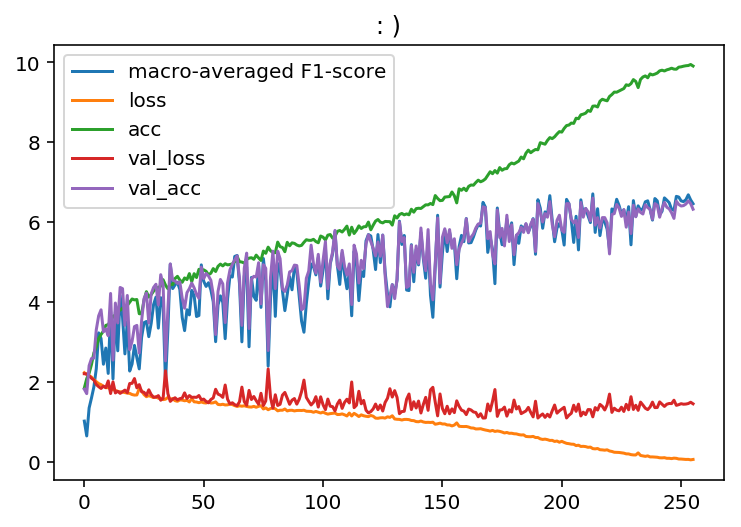

In [105]:
fig, ax = plt.subplots()
f1_score = np.array(F1_score)*10
loss = np.array(history['loss'])
acc = np.array(history['acc'])*10
val_loss = np.array(history['val_loss'])
val_acc = np.array(history['val_acc'])*10
plt.plot(f1_score, label='macro-averaged F1-score')
plt.plot(loss, label='loss')
plt.plot(acc, label='acc')
plt.plot(val_loss, label='val_loss')
plt.plot(val_acc, label='val_acc')
plt.title(": )")
plt.legend()

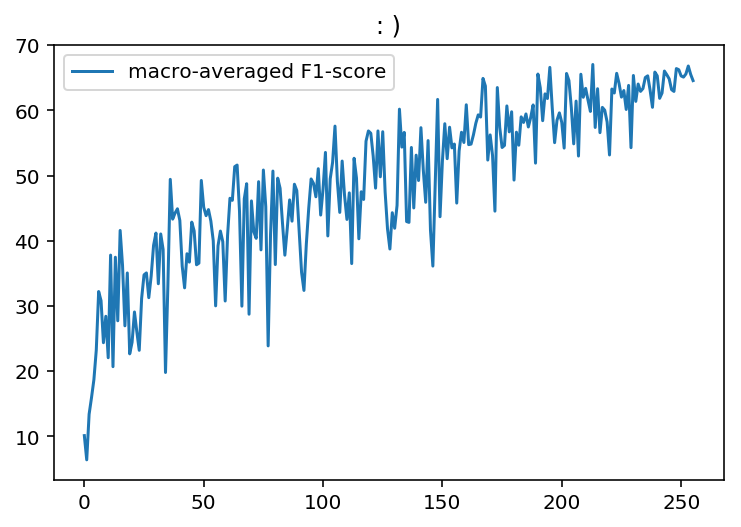

In [106]:
f1_score = np.array(F1_score)*100
plt.plot(f1_score, label='macro-averaged F1-score')
plt.title(": )")
plt.legend()

# Test